In this file i will use unsupervised learning techniques - clustering to try to discover new information about our data that isn't visible using simple statistical methods.
First i will import all the needed dependencies. 

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
plt.style.use('dark_background')

Most clustering techniques require numerical data , whereas our dataset is comprised of a lot of binary/onehot columns.
In order for clustering techniques to work , i will convert the dataset to a numeric representation using PCA.

In [12]:
data=pd.read_csv('./data/preprocessed_final_data.csv',sep=',')
y=data['y']
data=data.drop(['y'],axis=1)

The parameter passed to PCA suggests the initial information retention , i will use 0.9 which means 90% which is a good approximation.

In [13]:
pca=PCA(0.9)
pca.fit(data)
PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

t_d=pca.transform(data)
print("The pca components of the transformed dataset are : ",pca.n_components_)

The pca components of the transformed dataset are :  15


First i will use the k-means clustering method.In this method we provide the number of clusters that we want the dataset space to be split beforehand.
This means we need to determine the optimal number of clusters beforehand.A good k value is one that minimizes the intra-cluster sum of square distances between datapoints.
This means we can iterate k for different values and calculate the sum of squares each time and then plot the results for each k.
We can determine the optimal number of clusters by finding the plot point where there is an 'elbow' , the point where the graph slope starts to stabilize.

Lets calculate the intra cluster sum of squares for each value of k from 1 to 10.

In [14]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(t_d)
    sse.append(kmeans.inertia_)

Now i will plot the results to find the elbow point.

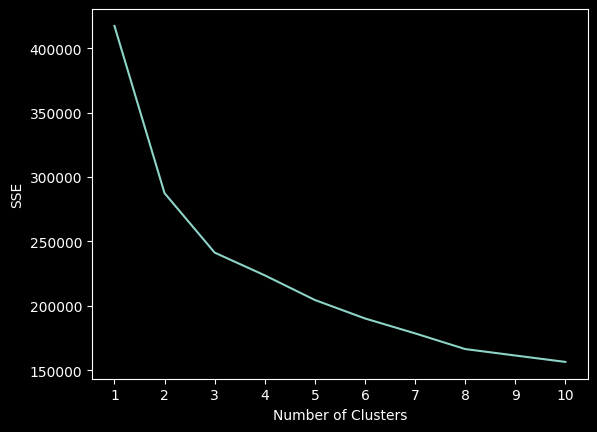

In [15]:
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

As we can see , the elbow point of the graph seems to be k=3.I will perform clustering now using k=3.

In [16]:
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)
kmeans.fit(t_d)

KMeans(init='random', n_clusters=3, n_init=10, random_state=42)

Assign each record its label based on clustering.

In [17]:
data['labels']=kmeans.labels_
data['y']=y

Now , i will try to see if there is any particular cluster with a high percentage of minority - 'yes' class records.

In [18]:
print("Cluster 0 has :",data[data.labels==0].query("y==1").shape[0]/data[data.labels==0].shape[0]," precent of minority samples")
print("Cluster 1:",data[data.labels==1].query("y==1").shape[0]/data[data.labels==1].shape[0]," precent of minority samples")
print("Cluster 2:",data[data.labels==2].query("y==1").shape[0]/data[data.labels==2].shape[0]," precent of minority samples")

Cluster 0 has : 0.04962810438290541  precent of minority samples
Cluster 1: 0.19456471672040535  precent of minority samples
Cluster 2: 0.6309263311451495  precent of minority samples


As we can see , cluster 1 has a high percentage of minority class records and cluster 0 has a higher percentage compared to the initial 11% present in our dataset.
Let's see how many records of the minority class each cluster contains.

In [19]:
print("Cluster 0 has ",data[data['labels']==0].shape[0]," total records"," where ",data[data['labels']==0].query("y==1").shape[0]," are minority class records")
print("Cluster 1 has ",data[data['labels']==1].shape[0]," total records"," where ",data[data['labels']==1].query("y==1").shape[0]," are minority class records")
print("Cluster 2 has ",data[data['labels']==2].shape[0]," total records"," where ",data[data['labels']==2].query("y==1").shape[0]," are minority class records")

Cluster 0 has  23797  total records  where  1181  are minority class records
Cluster 1 has  10855  total records  where  2112  are minority class records
Cluster 2 has  1371  total records  where  865  are minority class records


As we can see , even though cluster 1 had a high percentage of minority class records , most of these records exist in the other clusters , meaning we weren't able to split the dataset feature space that well and seperate the classes.

Now i will try to use DBSCAN clustering to try to yield any different results.DBSCAN comes from Density-Based Spatial Clustering of Applications with Noise.This clustering method tries to find high density aeras in our dataset feature space and will create density based clusters on its own , without needing to specify the number of clusters beforehand.Also this clustering method can also find outliers on its own.
DBSCAN has two hyperparameters which need to be tweaked in order to find their optimal price , minpts and eps , where eps is the max distance two datapoints can have to be considered neighbors and minpts is the number of neighbors needed in order to form a 'strong' point.
We can calculate the value for eps using the k-nearest neighbors technique , where we calculate the the average distance for each datapoint with each k nearest neighbors and then we can plot the distances at Y axis and number of datapoints on the X axis.
We can find the optimal value of eps at the point with max curvature of the resulting graph.
The optimal price of minpts cant be calculated with a certain method , but as the dataset size and dimensionality increases , we need to have a higher price for it.Generally its good for minpts to be higher that double the dimensionality of the dataset
For the n_neighbors value of KNN i will use the heuristic n_neighbors=sqrt(dataset_size)

In [20]:
print("The square root of the dataset record number is :",pow(data.shape[0],0.5))

The square root of the dataset record number is : 189.79726025419862


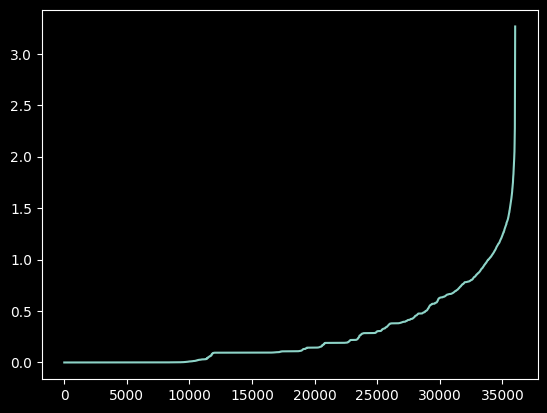

In [21]:
from sklearn.neighbors import NearestNeighbors
 
neighbors = NearestNeighbors(n_neighbors=190)
neighbors_fit = neighbors.fit(t_d)
distances, indices = neighbors_fit.kneighbors(t_d)
distances = np.sort(distances, axis=0)

distances = distances[:,1]
plt.plot(distances)

As we can see , the value 1.5 for eps is a good approximation for the point of max curvature.Afte all , eps is a hyperparameter , meaning there isnt an exact way to calculate a price for it , but only good approximations.
Also the same applies for minpts hyperparameter , we only have the requirment minpts>2*dataset_dimensionality

In [22]:
print("The minpts hyperparameter must be higher than: ",2*t_d.shape[1])

The minpts hyperparameter must be higher than:  30


I will choose 36 randomly.

In [23]:
from sklearn.cluster import DBSCAN
eps=1.5
dbscan = DBSCAN(eps=eps,min_samples=36)
dbscan.fit(t_d)

labels = dbscan.labels_
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6], dtype=int64)

As we can see , DBSCAN figured out there are 7 unique clusters based on the hyperparameter we provided and a group of outliers (labeled with -1).
Lets assign each record its label and check for intra cluster statistics based on the output column.

In [24]:
data['labels']=labels
data['y']=y

In [25]:
print("Cluster 0 is comprised of ",data[data.labels==0].query("y==1").shape[0]/data[data.labels==0].shape[0]," percent of minority class records.")
print("Cluster 1 is comprised of ",data[data.labels==1].query("y==1").shape[0]/data[data.labels==1].shape[0]," percent of minority class records.")
print("Cluster 2 is comprised of ",data[data.labels==2].query("y==1").shape[0]/data[data.labels==2].shape[0]," percent of minority class records.")
print("Cluster 3 is comprised of ",data[data.labels==3].query("y==1").shape[0]/data[data.labels==3].shape[0]," percent of minority class records.")
print("Cluster 4 is comprised of ",data[data.labels==4].query("y==1").shape[0]/data[data.labels==4].shape[0]," percent of minority class records.")
print("Cluster 5 is comprised of ",data[data.labels==5].query("y==1").shape[0]/data[data.labels==5].shape[0]," percent of minority class records.")
print("Cluster 6 is comprised of ",data[data.labels==6].query("y==1").shape[0]/data[data.labels==6].shape[0]," percent of minority class records.")
print("Outliers have ",data[data.labels==-1].query("y==1").shape[0]/data[data.labels==-1].shape[0]," percent of minority class records.")

Cluster 0 is comprised of  0.050140601341120486  percent of minority class records.
Cluster 1 is comprised of  0.03536977491961415  percent of minority class records.
Cluster 2 is comprised of  0.13954781319495924  percent of minority class records.
Cluster 3 is comprised of  0.07292759706190975  percent of minority class records.
Cluster 4 is comprised of  0.35926773455377575  percent of minority class records.
Cluster 5 is comprised of  0.35360824742268043  percent of minority class records.
Cluster 6 is comprised of  0.4075829383886256  percent of minority class records.
Outliers have  0.4453357100415924  percent of minority class records.


As we can see clusters 4-6 and outliers have a high percentage of minority class records.
Lets check how many minority class records are in each cluster.

In [26]:
print("Cluster 0 has ",data[data.labels==0].shape[0]," records where ", data[data.labels==0].query("y==1").shape[0]," are minority class records")
print("Cluster 1 has ",data[data.labels==1].shape[0]," records where ", data[data.labels==1].query("y==1").shape[0]," are minority class records")
print("Cluster 2 has ",data[data.labels==2].shape[0]," records where ", data[data.labels==2].query("y==1").shape[0]," are minority class records")
print("Cluster 3 has ",data[data.labels==3].shape[0]," records where ", data[data.labels==3].query("y==1").shape[0]," are minority class records")
print("Cluster 4 has ",data[data.labels==4].shape[0]," records where ", data[data.labels==4].query("y==1").shape[0]," are minority class records")
print("Cluster 5 has",data[data.labels==5].shape[0]," records where ", data[data.labels==5].query("y==1").shape[0]," are minority class records")
print("Cluster 6 has",data[data.labels==6].shape[0]," records where ", data[data.labels==6].query("y==1").shape[0]," are minority class records")
print("Outliers are ",data[data.labels==-1].shape[0]," records where ", data[data.labels==-1].query("y==1").shape[0]," are minority class records")

Cluster 0 has  23115  records where  1159  are minority class records
Cluster 1 has  622  records where  22  are minority class records
Cluster 2 has  5396  records where  753  are minority class records
Cluster 3 has  1906  records where  139  are minority class records
Cluster 4 has  437  records where  157  are minority class records
Cluster 5 has 970  records where  343  are minority class records
Cluster 6 has 211  records where  86  are minority class records
Outliers are  3366  records where  1499  are minority class records


As we can see , even though clusters 4-6 had a high percentage of minority class records , the number of records in these clusters is really small.
Most of our minority class records are in the outliers and cluster 0.Lets check the percentage of these minority class records per cluster out of the total minority class size.

In [27]:
print("Cluster 0 has ",data[data.labels==0].query("y==1").shape[0]/data[data.y==1].shape[0]," percent of total minority class records")
print("Cluster 1 has ",data[data.labels==1].query("y==1").shape[0]/data[data.y==1].shape[0]," percent of total minority class records")
print("Cluster 2 has ",data[data.labels==2].query("y==1").shape[0]/data[data.y==1].shape[0]," percent of total minority class records")
print("Cluster 3 has ",data[data.labels==3].query("y==1").shape[0]/data[data.y==1].shape[0]," percent of total minority class records")
print("Cluster 4 has ",data[data.labels==4].query("y==1").shape[0]/data[data.y==1].shape[0]," percent of total minority class records")
print("Cluster 5 has ",data[data.labels==5].query("y==1").shape[0]/data[data.y==1].shape[0]," percent of total minority class records")
print("Cluster 6 has ",data[data.labels==6].query("y==1").shape[0]/data[data.y==1].shape[0]," percent of total minority class records")
print("Outliers have ",data[data.labels==-1].query("y==1").shape[0]/data[data.y==1].shape[0]," percent of total minority class records")

Cluster 0 has  0.27873977873977873  percent of total minority class records
Cluster 1 has  0.005291005291005291  percent of total minority class records
Cluster 2 has  0.1810966810966811  percent of total minority class records
Cluster 3 has  0.03342953342953343  percent of total minority class records
Cluster 4 has  0.037758537758537755  percent of total minority class records
Cluster 5 has  0.08249158249158249  percent of total minority class records
Cluster 6 has  0.02068302068302068  percent of total minority class records
Outliers have  0.3605098605098605  percent of total minority class records


Still , even using this method we weren't able to separate the dataset feature space that well to separate each class.
As we can see , 36% percent of the minority class records are considered outliers using DBSCAN , meaning a large chunk of them has different characteristics compared to the rest of the dataset.